# Model Comparison

In this notebook we will create several new subreddit prediction models and systematically compare them.

While looking at new models we want to answer the following questions:
- What auxiliary information is important?
- Are different tokenizers better?
- How many words are needed in our Bag-of-Words?
- Do different classification algorithms (XGBoost, Support Vector Machine, Multinomial Logistic Regression, Random Forest)?
- Do more advanced embedding algorithms such as Averaged Word2Vec or Doc2Vec work better?

In order to make this process smoother, I have created custom classes which will hold the models and the results of our progress. These classes are defined in a seperate notebook which will be periodically updating while I'm working on this notebook. Because of this I will define an UPDATE function which will update objects of the main class. This will also include loading previously recorded data.

Obviously the first thing we have to do is load the reddit data.

In [99]:
import pandas as pd

df_raw = pd.read_csv('reddit_data.csv')
df_raw

,id,title,subreddit
0,t93ec3,This subreddit is closed for new posts and com...,announcements
1,pg006s,COVID denialism and policy clarifications,announcements
2,pbmy5y,"Debate, dissent, and protest on Reddit",announcements
3,nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements
4,mi01fg,Second,announcements
...,...,...,...
9456,10mvmxu,WIBTA if I planned and threw a St. Patty’s par...,AmItheAsshole
9457,10mvlnr,AITA for lashing out at my parents?,AmItheAsshole
9458,10mvlgl,AITA for not wanting to spend time with my wif...,AmItheAsshole
9459,10mvix4,WIBTA if I cancelled a vacation weekend becaus...,AmItheAsshole


In order to make this process smoother, I have created custom classes which will hold the models and the results of our progress. Let's run this seperate notebook and instantiate an object of that class. We will also add the reddit data at this stage.

In [100]:
#Run the other Notebook
%run Classes.ipynb

#Instantiate a new object and load the Reddit Data
obj = Subreddit_Predictor()
obj.add_data(df_raw)
obj.ready_data()

In [101]:
obj.full_data

,title,subreddit,subreddit_num
id,,,
t93ec3,This subreddit is closed for new posts and com...,announcements,3
pg006s,COVID denialism and policy clarifications,announcements,3
pbmy5y,"Debate, dissent, and protest on Reddit",announcements,3
nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements,3
mi01fg,Second,announcements,3
...,...,...,...
10mvmxu,WIBTA if I planned and threw a St. Patty’s par...,AmItheAsshole,0
10mvlnr,AITA for lashing out at my parents?,AmItheAsshole,0
10mvlgl,AITA for not wanting to spend time with my wif...,AmItheAsshole,0


Next we load all of the data we previously had access to in the Preliminary Assessment notebook.

In [102]:
import pickle as pkl

#Load the Results Data from the Naive model and the Human Guessing `model'
with open ("human_results.pkl", 'rb') as f:
    data = pkl.load(f)
obj.Results.loc['Human'] = data

with open ("naive_results.pkl", 'rb') as f:
    data = pkl.load(f)
obj.Results.loc['Naive'] = data

with open ("naive_results_mean.pkl", 'rb') as f:
    data = pkl.load(f)
obj.Cross_Validation_Results_avg.loc['Naive'] = data

with open ("naive_results_std.pkl", 'rb') as f:
    data = pkl.load(f)
obj.Cross_Validation_Results_std.loc['Naive'] = data

This allows us to compare the results of our new models with both the Naive Model we produced earlier and the Human Guessing results as well.

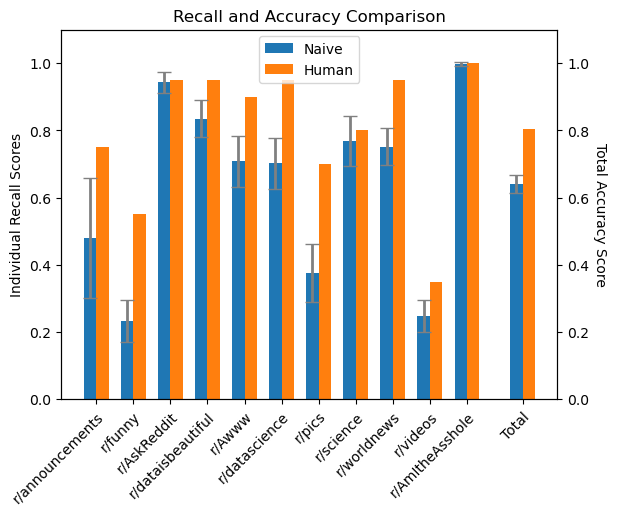

In [103]:
obj.compare([ 'Naive', 'Human'], error_bars=True)

Lastly, since we will be working on editing the Classes.ipynb file at the same time as this file, we will create some functions to help us along the way.

In [104]:
pickleable_attrs = ['raw_data', 'full_data', 'subreddits', 'X_train', 'Y_train', 'X_test', 'Y_test', 'Feature_Vectors',
                    'Models_info', '_le', '_train_index', '_test_index', 'Predictions', 'Results',
                    'Cross_Validation_Results', 'Cross_Validation_Results_avg', 'Cross_Validation_Results_std',
                    'ErrorBars', 'ALL_FEATURES']
nonpickleable_attrs = ['Classifiers', 'Models']


def SAVE_obj(obj, path):
    # Create a dictionary of the object's attributes
    obj_dict = {}
    for attr in pickleable_attrs:
        obj_dict[attr] = obj.__dict__[attr]

    # Save the dictionary to a file
    with open(path, 'wb') as f:
        pkl.dump(obj_dict, f)


def UPDATE_obj(obj, path):
    #Run the other Notebook
    %run Classes.ipynb

    #Instantiate a new object and load the Reddit Data
    new_obj = Subreddit_Predictor()

    # Save the attributes of the old object to a dictionary
    obj_dict = {}
    for attr in pickleable_attrs:
        obj_dict[attr] = obj.__dict__[attr]
        new_obj.__dict__[attr] = obj.__dict__[attr]

    SAVE_obj(new_obj, path)

    for attr in nonpickleable_attrs:
        new_obj.__dict__[attr] = obj.__dict__[attr]

    return new_obj


def LOAD_obj(path):
    # Load the dictionary from a file
    with open(path, 'rb') as f:
        obj_dict = pkl.load(f)

    # Instantiate a new object
    new_obj = Subreddit_Predictor()

    # Add the attributes from the dictionary to the new object
    for attr, value in obj_dict.items():
        new_obj.__dict__[attr] = value

    return new_obj


In [105]:
path = 'obj2.pkl'
SAVE_obj(obj, path)

In [106]:
obj = UPDATE_obj(obj, path)

## Feature Engineering

In [107]:
import re

df = obj.ALL_FEATURES.copy()

df['Aux: num_chars'] = df['title'].apply(lambda x: len(x))
df['Aux: num_caps'] =df['title'].apply(lambda s: len(re.findall(r'[A-Z]', s)))
df['Aux: num_lower'] = df['title'].apply(lambda s: len(re.findall(r'[a-z]', s)))
df['Aux: num_emojis'] = df['title'].apply(lambda s: len(re.findall(
        r'[\u2600-\u27bf]' # Miscellaneous Symbols and Pictographs (☀️, 🌁, 🌊)
        r'|[\U0001f300-\U0001f5ff]' # Emoticons (🌞, 🌝, 🌚)
        r'|[\U0001f600-\U0001f64f]' # Transport and Map Symbols (🚗, 🚕, 🚆)
        r'|[\U0001f680-\U0001f6ff]' # Transport and Map Symbols (🚁, 🚲, 🛴)
        r'|[\u2b00-\u2bff]' # Additional emoticons (⬛, ❤️, 🔥)
        , s)))

obj.ALL_FEATURES = df
obj.ALL_FEATURES

,title,subreddit,subreddit_num,Aux: num_chars,Aux: num_caps,Aux: num_lower,Aux: num_emojis
id,,,,,,,
t93ec3,This subreddit is closed for new posts and com...,announcements,3,160,4,125,0
pg006s,COVID denialism and policy clarifications,announcements,3,41,5,32,0
pbmy5y,"Debate, dissent, and protest on Reddit",announcements,3,38,2,29,0
nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements,3,40,5,30,0
mi01fg,Second,announcements,3,6,1,5,0
...,...,...,...,...,...,...,...
10mvmxu,WIBTA if I planned and threw a St. Patty’s par...,AmItheAsshole,0,115,8,84,0
10mvlnr,AITA for lashing out at my parents?,AmItheAsshole,0,35,4,24,0
10mvlgl,AITA for not wanting to spend time with my wif...,AmItheAsshole,0,65,4,48,0


In [108]:
from collections import Counter


# Create a list of all characters in the title column

training = pd.DataFrame(obj.X_train)

all_characters = ''.join(training['title'])
total_chars = len(all_characters)

# Create a Counter object to count the occurrences of each word
character_count = Counter(all_characters)
# Create a list of words that appear more than 100 times
infrequent_chars = [char for char, count in character_count.items() if ((count < total_chars/100) & (count > 10))]
#infrequent_chars = [char for char, count in character_count.items() if (count > 10)]

# Print the list of frequent words
print(infrequent_chars)

['W', 'b', '?', 'N', 'O', 'T', 'V', '.', 'L', 'v', "'", '9', '1', '0', 'A', 'I', 'D', 'z', '&', 'M', 'Y', '-', 'S', 'k', '[', 'j', ']', ',', 'x', '’', 'K', '(', ')', 'P', '8', 'C', 'R', '/', '6', ':', 'U', 'F', '2', '4', 'E', 'B', 'X', 'G', '3', '$', '5', 'q', '|', 'H', '#', '%', 'J', '—', '😍', '!', '…', '‘', '7', '"', 'Q', '“', '”', 'Z', '–', '♥', '️', '🤣', 'é', '😂', '🥰', '❤', '+', ';', '*', 'ا', '=', '█']


In [109]:
df = obj.ALL_FEATURES.copy()

new_cols = {'BoC: ' + str(char): df['title'].apply(lambda x: x.count(char)) for char in infrequent_chars}
df = pd.concat([df, pd.DataFrame(new_cols)], axis = 1)


obj.ALL_FEATURES = df
obj.ALL_FEATURES

,title,subreddit,subreddit_num,Aux: num_chars,Aux: num_caps,Aux: num_lower,Aux: num_emojis,BoC: W,BoC: b,BoC: ?,...,BoC: é,BoC: 😂,BoC: 🥰,BoC: ❤,BoC: +,BoC: ;,BoC: *,BoC: ا,BoC: =,BoC: █
id,,,,,,,,,,,,,,,,,,,,,
t93ec3,This subreddit is closed for new posts and com...,announcements,3,160,4,125,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
pg006s,COVID denialism and policy clarifications,announcements,3,41,5,32,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pbmy5y,"Debate, dissent, and protest on Reddit",announcements,3,38,2,29,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements,3,40,5,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mi01fg,Second,announcements,3,6,1,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10mvmxu,WIBTA if I planned and threw a St. Patty’s par...,AmItheAsshole,0,115,8,84,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
10mvlnr,AITA for lashing out at my parents?,AmItheAsshole,0,35,4,24,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10mvlgl,AITA for not wanting to spend time with my wif...,AmItheAsshole,0,65,4,48,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [110]:
def clean_data(df):
    """
    :param df: Pandas DataFrame with a column 'title'
    :return: original df with the contents of the 'title' column altered. All lowercase. Replace "[oc]", "(oc)", and "[nsfw]" with "_oc_" and "_nsfw_" respectively.
    """

    df['title'] = df['title'].apply(lambda s: s.lower())

    df['title'] = df['title'].apply(lambda s: s.replace("[oc]", "_oc_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(oc)", "_oc_"))
    df['title'] = df['title'].apply(lambda s: s.replace("[nsfw]", "_nsfw_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(nsfw)", "_nsfw_"))
    df['title'] = df['title'].apply(lambda s: s.replace("[wip]", "_wip_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(wip)", "_wip_"))

    return df

In [111]:
import nltk

df = clean_data(obj.ALL_FEATURES)

df['title_tokens'] = df['title'].apply(nltk.word_tokenize)

obj.ALL_FEATURES = df
obj.ALL_FEATURES

,title,subreddit,subreddit_num,Aux: num_chars,Aux: num_caps,Aux: num_lower,Aux: num_emojis,BoC: W,BoC: b,BoC: ?,...,BoC: 😂,BoC: 🥰,BoC: ❤,BoC: +,BoC: ;,BoC: *,BoC: ا,BoC: =,BoC: █,title_tokens
id,,,,,,,,,,,,,,,,,,,,,
t93ec3,this subreddit is closed for new posts and com...,announcements,3,160,4,125,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"[this, subreddit, is, closed, for, new, posts,..."
pg006s,covid denialism and policy clarifications,announcements,3,41,5,32,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[covid, denialism, and, policy, clarifications]"
pbmy5y,"debate, dissent, and protest on reddit",announcements,3,38,2,29,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"[debate, ,, dissent, ,, and, protest, on, reddit]"
nw2hs6,sunsetting secret santa and reddit gifts,announcements,3,40,5,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[sunsetting, secret, santa, and, reddit, gifts]"
mi01fg,second,announcements,3,6,1,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[second]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10mvmxu,wibta if i planned and threw a st. patty’s par...,AmItheAsshole,0,115,8,84,0,1,0,1,...,0,0,0,0,0,0,0,0,0,"[wibta, if, i, planned, and, threw, a, st., pa..."
10mvlnr,aita for lashing out at my parents?,AmItheAsshole,0,35,4,24,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[aita, for, lashing, out, at, my, parents, ?]"
10mvlgl,aita for not wanting to spend time with my wif...,AmItheAsshole,0,65,4,48,0,0,1,1,...,0,0,0,0,0,0,0,0,0,"[aita, for, not, wanting, to, spend, time, wit..."


In [112]:
from nltk.probability import FreqDist

def get_vocab(corpus, tokenizer=nltk.word_tokenize, num_words=False, min_frequency=2):
    """
    :param corpus: a Pandas Series, or other iterable of cleaned text sentences.
    :param tokenizer: a function that takes in a sentence and outputs a list of tokens in that sentence.
    :param num_words: If an integer is given, then this is the max number of words in the vocab.
    :param min_frequency: If an integer is given, then this is the minimum number of times a word must appear in the corpus to be included in the vocab
    :return: A list of all of the tokens in our vocab.
    """
    tokenized_corpus = [tokenizer(corpus.loc[id]['title']) for id in corpus.index]
    flat_list = [word for sublist in tokenized_corpus for word in sublist]
    freq_dist = FreqDist(flat_list)
    vocab = [word for word, freq in freq_dist.items() if freq >= min_frequency]
    if num_words:
        vocab = sorted(vocab, key=lambda x: freq_dist[x], reverse=True)
        vocab = vocab[:min(num_words, len(vocab))]
    vocab.sort()
    return vocab

In [113]:
from tqdm import tqdm

training = clean_data(training)
vocab = get_vocab(training)

df = obj.ALL_FEATURES.copy()
new_cols = {'BoW: ' + word: df['title_tokens'].apply(lambda x: Counter(x)[word]) for word in tqdm(vocab)}
new_df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)
obj.ALL_FEATURES = new_df

obj.ALL_FEATURES

100%|██████████| 6401/6401 [01:50<00:00, 58.02it/s]


,title,subreddit,subreddit_num,Aux: num_chars,Aux: num_caps,Aux: num_lower,Aux: num_emojis,BoC: W,BoC: b,BoC: ?,...,BoW: 😍💕,BoW: 😍😍,BoW: 😍😍😍,BoW: 😴,BoW: 🙏,BoW: 🤣,BoW: 🥰,BoW: 🥹,BoW: 🥺,BoW: 🧡
id,,,,,,,,,,,,,,,,,,,,,
t93ec3,this subreddit is closed for new posts and com...,announcements,3,160,4,125,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
pg006s,covid denialism and policy clarifications,announcements,3,41,5,32,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pbmy5y,"debate, dissent, and protest on reddit",announcements,3,38,2,29,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
nw2hs6,sunsetting secret santa and reddit gifts,announcements,3,40,5,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mi01fg,second,announcements,3,6,1,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10mvmxu,wibta if i planned and threw a st. patty’s par...,AmItheAsshole,0,115,8,84,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
10mvlnr,aita for lashing out at my parents?,AmItheAsshole,0,35,4,24,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10mvlgl,aita for not wanting to spend time with my wif...,AmItheAsshole,0,65,4,48,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [114]:
from nltk import pos_tag

df = obj.ALL_FEATURES.copy()

df['pos_tokens'] = df['title_tokens'].apply(lambda x: pos_tag(x))

# Get the list of unique parts of speech
pos_tags = list(set([tag for tokens in df['pos_tokens'] for word, tag in tokens]))

# Add a new column for each part of speech
for pos in tqdm(pos_tags):
    df['PoS: ' + str(pos)] = df['pos_tokens'].apply(lambda x: len([word for word, tag in x if tag == pos]))

obj.ALL_FEATURES = df
obj.ALL_FEATURES


100%|██████████| 45/45 [00:00<00:00, 100.60it/s]


,title,subreddit,subreddit_num,Aux: num_chars,Aux: num_caps,Aux: num_lower,Aux: num_emojis,BoC: W,BoC: b,BoC: ?,...,PoS: ``,PoS: RB,PoS: NNPS,PoS: '',PoS: POS,PoS: IN,PoS: WDT,PoS: FW,PoS: VB,PoS: UH
id,,,,,,,,,,,,,,,,,,,,,
t93ec3,this subreddit is closed for new posts and com...,announcements,3,160,4,125,0,0,1,0,...,0,0,0,0,0,2,0,0,2,0
pg006s,covid denialism and policy clarifications,announcements,3,41,5,32,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pbmy5y,"debate, dissent, and protest on reddit",announcements,3,38,2,29,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
nw2hs6,sunsetting secret santa and reddit gifts,announcements,3,40,5,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mi01fg,second,announcements,3,6,1,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10mvmxu,wibta if i planned and threw a st. patty’s par...,AmItheAsshole,0,115,8,84,0,1,0,1,...,0,2,0,0,0,2,0,0,1,0
10mvlnr,aita for lashing out at my parents?,AmItheAsshole,0,35,4,24,0,0,0,1,...,0,0,0,0,0,2,0,0,0,0
10mvlgl,aita for not wanting to spend time with my wif...,AmItheAsshole,0,65,4,48,0,0,1,1,...,0,1,0,0,1,2,0,0,1,0


In [115]:
def rename_columns(df):
    new_cols = []
    for col in df.columns:
        new_col = col.replace("[", "open_bracket").replace("]", "close_bracket").replace("<", "less_than")
        new_cols.append(new_col)
    df.columns = new_cols
    return df

obj.ALL_FEATURES = rename_columns(obj.ALL_FEATURES)


## Classifiers

In [116]:

from sklearn.ensemble import RandomForestClassifier


def _RandomForest_train(X_train, Y_train):
    # Initialize the Random Forest model
    rf = RandomForestClassifier()
    # Train the model on the input data
    rf.fit(X_train, Y_train)
    # Output the trained model
    return rf


def _RandomForest_predict(title_vectors, model):
    # Make predictions on the input data
    predictions = model.predict(title_vectors)
    # Output the predictions as a pandas series
    return pd.Series(predictions)


RF = Classifier('RF')
RF._train = _RandomForest_train
RF._predict = _RandomForest_predict
obj.add_classifier(RF)


In [117]:
import xgboost as xgb

def _XGBoost_train(X_train, Y_train):
    # Initialize the XGBoost model
    xgb_model = xgb.XGBClassifier()
    # Train the model on the input data
    xgb_model.fit(X_train, Y_train)
    # Output the trained model
    return xgb_model

def _XGBoost_predict(title_vectors, model):
    # Make predictions on the input data
    predictions = model.predict(title_vectors)
    # Output the predictions as a pandas series
    return pd.Series(predictions)

XGB = Classifier('XGB')
XGB._train = _XGBoost_train
XGB._predict = _XGBoost_predict
obj.add_classifier(XGB)


In [118]:
from sklearn.linear_model import LogisticRegression

def _LogisticRegression_train(X_train, Y_train):
    # Initialize the logistic regression model
    logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
    # Train the model on the input data
    logreg.fit(X_train, Y_train)
    # Output the trained model
    return logreg

def _LogisticRegression_predict(title_vectors, model):
    # Make predictions on the input data
    predictions = model.predict(title_vectors)
    # Output the predictions as a pandas series
    return pd.Series(predictions)

LogReg = Classifier('LogReg')
LogReg._train = _LogisticRegression_train
LogReg._predict = _LogisticRegression_predict
obj.add_classifier(LogReg)

## Feature Selection

In [119]:
aux_features = [col for col in obj.ALL_FEATURES.columns if 'Aux:' in col]
BoC_features = [col for col in obj.ALL_FEATURES.columns if 'BoC:' in col]
PoS_features = [col for col in obj.ALL_FEATURES.columns if 'PoS:' in col]
BoW_features = [col for col in obj.ALL_FEATURES.columns if 'BoW:' in col]




In [120]:
obj.new_train_model('Aux', aux_features, 'RF' , description="A Random Forest model using only Auxiliary features.")
obj.new_train_model('BoC', BoC_features, 'RF' , description="A Random Forest model using only Bag-of-Character features.")
obj.new_train_model('BoC+Aux', aux_features + BoC_features , 'RF' , description="A Random Forest model using Bag-of-Character + auxiliary features.")

In [121]:
obj.Predictions

,title,actual
id,,
10m7d9b,Egypt plans to allot land to Indian industries...,worldnews
105bmlo,the princess resting ❤️,Awww
zz0muf,Contour Map of the Sub Continent [OC],dataisbeautiful
10q4jw2,James Gunn DC Slate Announcement,videos
10kzv8m,Zambian student who died fighting for Russia i...,worldnews
...,...,...
10b8czt,Sociodemographic factors such as mortality rat...,science
10l60a3,Study shows how cells prevent harmful extra DN...,science
10lrffj,My adorable pet rats Banana (gray) and Donut (...,Awww


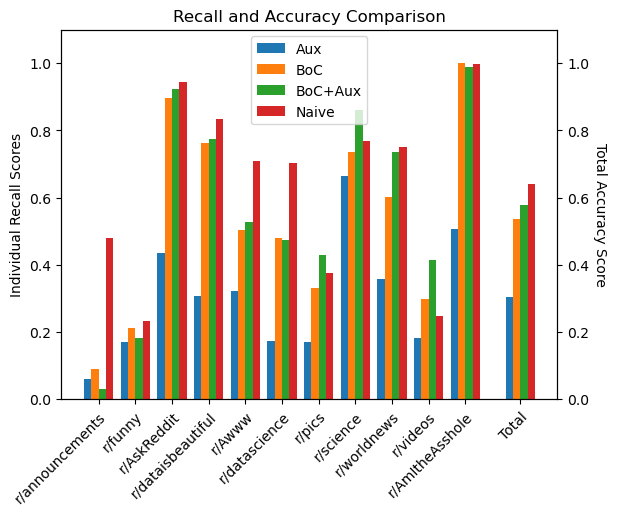

In [122]:
obj.new_test_model('Aux')
obj.new_test_model('BoC')
obj.new_test_model('BoC+Aux')


obj.compare(['Aux', 'BoC', 'BoC+Aux', 'Naive'])


In [123]:
obj.new_train_model('XGB_aux_compare', aux_features , 'XGB',  description="An XGBoost model using only auxiliary features.")
obj.new_test_model('XGB_aux_compare')

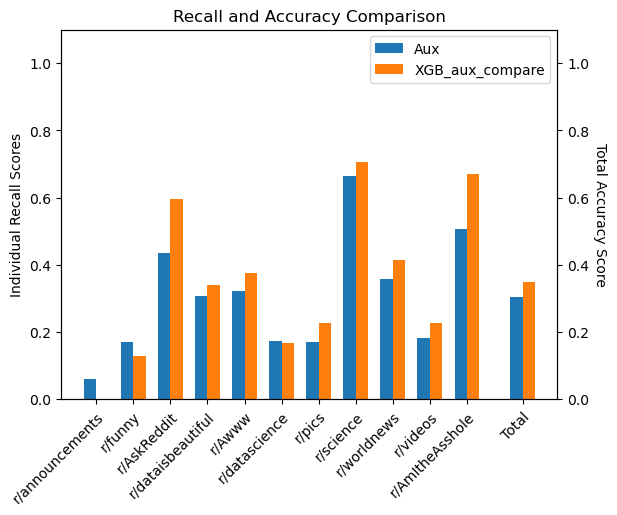

In [124]:
obj.compare(['Aux', 'XGB_aux_compare'])

In [125]:
obj.new_train_model('LogReg_aux_compare', aux_features , 'LogReg',  description="A multinomial logistic regression model using only auxiliary features.")
obj.new_test_model('LogReg_aux_compare')

C:\Users\raino\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


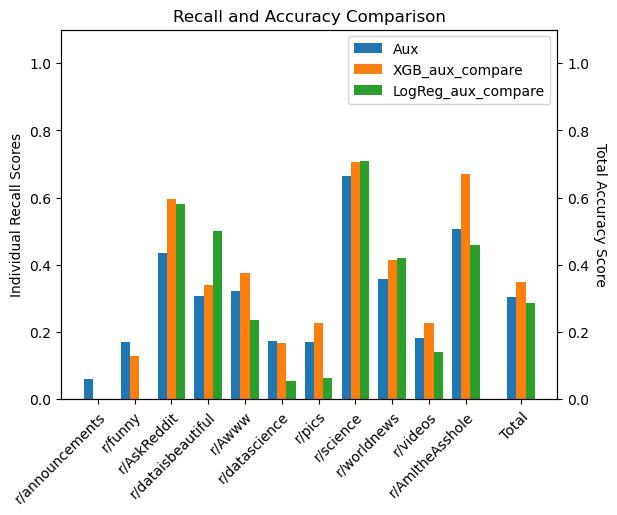

In [126]:
obj.compare(['Aux', 'XGB_aux_compare','LogReg_aux_compare' ])

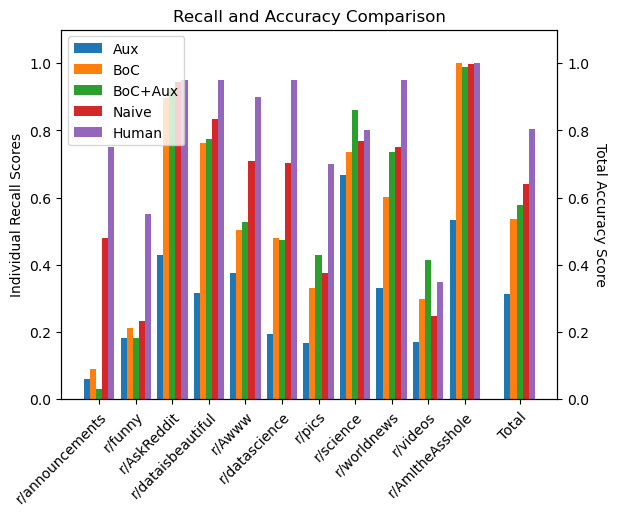

In [127]:
obj = UPDATE_obj(obj, path)

obj.new_train_model('Aux', aux_features, 'RF' , description="A Random Forest model using only Auxiliary features.")
obj.new_test_model('Aux')


obj.compare(['Aux', 'BoC', 'BoC+Aux', 'Naive', 'Human'])

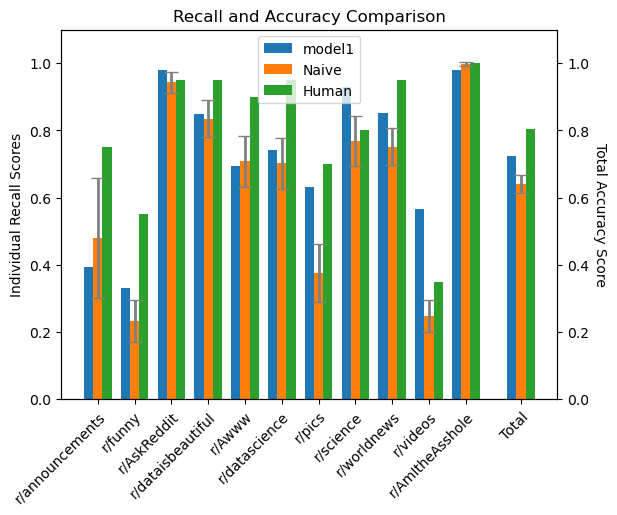

In [128]:
obj.new_train_model('model1', aux_features + BoW_features, 'XGB' , description="An XGB model using all BoW features + Aux features.")
obj.new_test_model('model1')
obj.compare(['model1', 'Naive', 'Human'], error_bars=True)

In [129]:
import copy

dic = {'a':3}
dic2 = copy.copy(dic)
dic2['b'] = 4
print(dic)
print(dic2)

{'a': 3}
{'a': 3, 'b': 4}


In [130]:
obj.new_test_model('Aux')
obj.new_test_model('BoC')
obj.new_test_model('BoC+Aux')

In [131]:
obj.ALL_FEATURES

,title,subreddit,subreddit_num,Aux: num_chars,Aux: num_caps,Aux: num_lower,Aux: num_emojis,BoC: W,BoC: b,BoC: ?,...,PoS: ``,PoS: RB,PoS: NNPS,PoS: '',PoS: POS,PoS: IN,PoS: WDT,PoS: FW,PoS: VB,PoS: UH
id,,,,,,,,,,,,,,,,,,,,,
t93ec3,this subreddit is closed for new posts and com...,announcements,3,160,4,125,0,0,1,0,...,0,0,0,0,0,2,0,0,2,0
pg006s,covid denialism and policy clarifications,announcements,3,41,5,32,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pbmy5y,"debate, dissent, and protest on reddit",announcements,3,38,2,29,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
nw2hs6,sunsetting secret santa and reddit gifts,announcements,3,40,5,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mi01fg,second,announcements,3,6,1,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10mvmxu,wibta if i planned and threw a st. patty’s par...,AmItheAsshole,0,115,8,84,0,1,0,1,...,0,2,0,0,0,2,0,0,1,0
10mvlnr,aita for lashing out at my parents?,AmItheAsshole,0,35,4,24,0,0,0,1,...,0,0,0,0,0,2,0,0,0,0
10mvlgl,aita for not wanting to spend time with my wif...,AmItheAsshole,0,65,4,48,0,0,1,1,...,0,1,0,0,1,2,0,0,1,0


In [132]:


pos_tag(nltk.word_tokenize("Hello, world!")).count(('Hello', ))

0

In [133]:
tokenized_corpus = [nltk.word_tokenize(training.loc[id]['title']) for id in training.index]
tokenized_corpus

[['what',
  'do',
  'you',
  'find',
  'to',
  'be',
  'the',
  'most',
  'disrespectful',
  'subreddit',
  'here',
  '?'],
 ['not', 'gon', 'na', 'eat', 'there'],
 ['very',
  'content',
  'cat',
  '.',
  'loving',
  'the',
  'sun',
  'and',
  'ofcourse',
  'the',
  'heated',
  'cob',
  'bench',
  'does',
  "n't",
  'hurt',
  'either',
  '.'],
 ['9', 'year', 'old', 'drifting', 'a', 'car'],
 ['watchmen', '10'],
 ['lounging', 'out'],
 ['aita',
  'for',
  'telling',
  'my',
  'mother',
  'that',
  'my',
  'sister',
  'has',
  'no',
  'manners'],
 ['daniel',
  'díaz',
  '&',
  'miguel',
  'yanover',
  '-',
  'a',
  'stab',
  'in',
  'the',
  'dark',
  '[',
  'instrumental',
  'dark',
  'jazz',
  ']',
  'electric',
  'bass',
  'guitar',
  ',',
  'electric',
  'piano',
  ',',
  'acoustic',
  'drums',
  ',',
  'tenor',
  'saxophone',
  '.'],
 ['what',
  '’',
  's',
  'the',
  'proper',
  'way',
  'to',
  'respectfully',
  'sign',
  'of',
  'to',
  'comment',
  'after',
  'a',
  'discussion',
 

In [134]:
training.loc['10q4vr2']['title']

'what do you find to be the most disrespectful subreddit here?'

In [135]:
training = clean_data(training)
get_vocab(training)

['!',
 '#',
 '$',
 '%',
 '&',
 "'",
 "''",
 "'d",
 "'data",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'the",
 "'ve",
 "'war",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '--',
 '.',
 '..',
 '...',
 '....',
 '.....',
 '/',
 '//',
 '/r/worldnews',
 '0',
 '0.4',
 '000',
 '1',
 '1,000',
 '1-10',
 '1.2',
 '1.5',
 '10',
 '10,000',
 '10-11',
 '100',
 '1000',
 '100k',
 '100m',
 '101',
 '10k',
 '10pm',
 '11',
 '112',
 '12',
 '12-4',
 '13',
 '13th',
 '14',
 '15',
 '150',
 '15th',
 '16',
 '160',
 '18',
 '1880',
 '19',
 '1910',
 '1940',
 '1945',
 '1950s',
 '1960',
 '1970',
 '1970s',
 '1980',
 '1980s',
 '1981-2022',
 '1985',
 '1987',
 '1990',
 '1990s',
 '1991',
 '1993',
 '1995',
 '1996',
 '1998',
 '1am',
 '1k',
 '1st',
 '2',
 '2,000',
 '2.4',
 '20',
 '20,000',
 '200',
 '2000',
 '2001',
 '2003',
 '2007',
 '2008',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2018-2022',
 '2019',
 '2019-2022',
 '2020',
 '2021',
 '2021-2022',
 '2021.',
 '2022',
 '2022.',
 '2023',
 '2024',
 '2026',


In [136]:
df

,title,subreddit,subreddit_num,Aux: num_chars,Aux: num_caps,Aux: num_lower,Aux: num_emojis,BoC: W,BoC: b,BoC: ?,...,PoS: ``,PoS: RB,PoS: NNPS,PoS: '',PoS: POS,PoS: IN,PoS: WDT,PoS: FW,PoS: VB,PoS: UH
id,,,,,,,,,,,,,,,,,,,,,
t93ec3,this subreddit is closed for new posts and com...,announcements,3,160,4,125,0,0,1,0,...,0,0,0,0,0,2,0,0,2,0
pg006s,covid denialism and policy clarifications,announcements,3,41,5,32,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pbmy5y,"debate, dissent, and protest on reddit",announcements,3,38,2,29,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
nw2hs6,sunsetting secret santa and reddit gifts,announcements,3,40,5,30,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mi01fg,second,announcements,3,6,1,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10mvmxu,wibta if i planned and threw a st. patty’s par...,AmItheAsshole,0,115,8,84,0,1,0,1,...,0,2,0,0,0,2,0,0,1,0
10mvlnr,aita for lashing out at my parents?,AmItheAsshole,0,35,4,24,0,0,0,1,...,0,0,0,0,0,2,0,0,0,0
10mvlgl,aita for not wanting to spend time with my wif...,AmItheAsshole,0,65,4,48,0,0,1,1,...,0,1,0,0,1,2,0,0,1,0


### Naive Model+

The first thing we need to do is recreate our Naive Model. The embedding process uses Bag-of-Words. To make our lives easier in the future, we will create a generalized BoW embedding that can be easily modified.


*Cleaning* - Make everythign lower case and fix some common terms like "[oc]" to make it easier for the tokenizer
*Embedding* - "Training" a BoW model is really just creating a vacob list. We use NLTK's tokenizer
*Classifying* - As in our first approach we will use Random Forrest.

In [137]:
def clean_data(df):
    """
    :param df: Pandas DataFrame with a column 'title', or a Series
    :return: original df with the contents of the 'title' column altered. All lowercase. Replace "[oc]", "(oc)", and "[nsfw]" with "_oc_" and "_nsfw_" respectively.
    """

    if type(df) == pd.Series:
        df = pd.DataFrame(df)
        series = True
    else:
        series = False

    df['title'] = df['title'].apply(lambda s: s.lower())

    df['title'] = df['title'].apply(lambda s: s.replace("[oc]", "_oc_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(oc)", "_oc_"))
    df['title'] = df['title'].apply(lambda s: s.replace("[nsfw]", "_nsfw_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(nsfw)", "_nsfw_"))
    df['title'] = df['title'].apply(lambda s: s.replace("[wip]", "_wip_"))
    df['title'] = df['title'].apply(lambda s: s.replace("(wip)", "_wip_"))
    df['title'] = df['title'].apply(lambda s: s.replace("[serious]", "_serious_"))

    if series: df = df['title']

    return df

In [138]:
import nltk

def get_vocab(corpus, tokenizer=nltk.word_tokenize, num_words=False, min_frequency=2):
    """
    :param corpus: a Pandas Series, or other iterable of cleaned text sentences.
    :param tokenizer: a function that takes in a sentence and outputs a list of tokens in that sentence.
    :param num_words: If an integer is given, then this is the max number of words in the vocab.
    :param min_frequency: If an integer is given, then this is the minimum number of times a word must appear in the corpus to be included in the vocab
    :return: A list of all of the tokens in our vocab.
    """
    tokenized_corpus = [tokenizer(sentence) for sentence in corpus]
    flat_list = [word for sublist in tokenized_corpus for word in sublist]
    freq_dist = FreqDist(flat_list)
    vocab = [word for word, freq in freq_dist.items() if freq >= min_frequency]
    if num_words:
        vocab = sorted(vocab, key=lambda x: freq_dist[x], reverse=True)
        vocab = vocab[:min(num_words, len(vocab))]
    vocab.sort()
    return vocab


In [139]:

from tqdm import tqdm


def _BoW_embed(titles, vocab, tokenizer=nltk.word_tokenize):
    """
    :param titles: A Pandas Series of titles to embed
    :param vocab: A List of all the words in the vocab
    :return:
    """
    df = pd.DataFrame(titles)
    df['title_tokens'] = df['title'].apply(tokenizer)
    new_cols = {'BoW: ' + word: df['title_tokens'].apply(lambda x: Counter(x)[word]) for word in tqdm(vocab)}
    #new_cols['Not in BoW'] = df['title_tokens'].apply(lambda lis: count_not_in_list2(lis, vocab))
    new_df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)
    new_df = new_df.drop(columns=['title', 'title_tokens'])

    return new_df


In [140]:
from nltk.probability import FreqDist
from collections import Counter


#Naive_BoW = Vectorizer('Naive BoW')

In [141]:
obj.Models_info

{'Aux': {'feature_list': ['Aux: num_chars',
   'Aux: num_caps',
   'Aux: num_lower',
   'Aux: num_emojis'],
  'classifierName': 'RF',
  'description': 'A Random Forest model using only Auxiliary features.'},
 'BoC': {'feature_list': ['BoC: W',
   'BoC: b',
   'BoC: ?',
   'BoC: N',
   'BoC: O',
   'BoC: T',
   'BoC: V',
   'BoC: .',
   'BoC: L',
   'BoC: v',
   "BoC: '",
   'BoC: 9',
   'BoC: 1',
   'BoC: 0',
   'BoC: A',
   'BoC: I',
   'BoC: D',
   'BoC: z',
   'BoC: &',
   'BoC: M',
   'BoC: Y',
   'BoC: -',
   'BoC: S',
   'BoC: k',
   'BoC: open_bracket',
   'BoC: j',
   'BoC: close_bracket',
   'BoC: ,',
   'BoC: x',
   'BoC: ’',
   'BoC: K',
   'BoC: (',
   'BoC: )',
   'BoC: P',
   'BoC: 8',
   'BoC: C',
   'BoC: R',
   'BoC: /',
   'BoC: 6',
   'BoC: :',
   'BoC: U',
   'BoC: F',
   'BoC: 2',
   'BoC: 4',
   'BoC: E',
   'BoC: B',
   'BoC: X',
   'BoC: G',
   'BoC: 3',
   'BoC: $',
   'BoC: 5',
   'BoC: q',
   'BoC: |',
   'BoC: H',
   'BoC: #',
   'BoC: %',
   'BoC: J',
   'B

In [142]:
try:
    result = 1 + max(list(obj.Cross_Validation_Results.loc['Naive Model'].index))
except KeyError:
    print('KeyError occurred')

KeyError occurred


In [143]:
obj.validate('Naive Model', 1)

KeyError: 'Naive Model'

In [ ]:
#Naive_BoW._train = (lambda corpus: get_vocab(clean_data(corpus), num_words=False, min_frequency=2))

In [ ]:
#Naive_BoW._embed = (lambda titles, vocab: _BoW_embed(clean_data(titles), vocab))


In [ ]:
#temp_X_train = obj.X_train
#Naive_BoW.train(temp_X_train)

In [ ]:
#Naive_BoW.embed(temp_X_train)


In [ ]:
from nltk.probability import FreqDist
from collections import Counter


Naive_BoW = Vectorizer('Naive BoW')
Naive_BoW._train = (lambda corpus: get_vocab(clean_data(corpus), num_words=False, min_frequency=2))
Naive_BoW._embed = (lambda titles, vocab: _BoW_embed(clean_data(titles), vocab))
temp_X_train = obj.X_train
Naive_BoW.train(temp_X_train)
Naive_BoW.embed(temp_X_train)


In [ ]:

from sklearn.ensemble import RandomForestClassifier


def _RandomForest_train(X_train, Y_train):
    # Initialize the Random Forest model
    rf = RandomForestClassifier()
    # Train the model on the input data
    rf.fit(X_train, Y_train)
    # Output the trained model
    return rf


def _RandomForest_predict(title_vectors, model):
    # Make predictions on the input data
    predictions = model.predict(title_vectors)
    # Output the predictions as a pandas series
    return pd.Series(predictions)


In [ ]:

RF = Classifier('RF')
RF._train = _RandomForest_train
RF._predict = _RandomForest_predict

obj.add_vectorizer(Naive_BoW)
obj.add_feature_vectors('Naive BoW')
obj.add_classifier(RF)
obj.train_model('Naive Model', 'Naive BoW', 'RF',
                description="The Naive model using a full BoW vocab and RF with default parameters."
                )
obj.test_model('Naive Model')
obj.compare(['Naive Model'])

In [ ]:
obj.full_data

In [ ]:
obj.ALL_FEATURES

In [ ]:
obj.train_model.info()

In [ ]:
obj.Classifiers

In [ ]:
a = Classifier('test')

In [ ]:
from sklearn.ensemble import RandomForestClassifier


def _RandomForest_train(X_train, Y_train):
    # Initialize the Random Forest model
    rf = RandomForestClassifier()
    # Train the model on the input data
    rf.fit(X_train, Y_train)
    # Output the trained model
    return rf


def _RandomForest_predict(title_vectors, model):
    # Make predictions on the input data
    predictions = model.predict(title_vectors)
    # Output the predictions as a pandas series
    return pd.Series(predictions)


In [ ]:

RF = Classifier('RF')
RF._train = _RandomForest_train
RF._predict = _RandomForest_predict

obj.add_classifier(RF)

In [ ]:
obj.X_train

In [ ]:
df = obj.ALL_FEATURES[['Aux: num_chars', 'Aux: num_caps']]
df

In [ ]:
aux_features = obj.ALL_FEATURES.loc[:, list(obj.ALL_FEATURES.columns.str.startswith('Aux:'))]
aux_features

In [ ]:
type(obj.ALL_FEATURES.columns.str.startswith('Aux:'))

In [ ]:
obj.full_data['subreddit'].loc[obj._train_index]

In [ ]:
import pickle as pkl

pickleable_attrs = ['raw_data', 'full_data', 'subreddits', 'X_train', 'Y_train', 'X_test', 'Y_test', 'Feature_Vectors',  'Models_info', '_le', '_train_index', '_test_index', 'Predictions', 'Results', 'Cross_Validation_Results', 'Cross_Validation_Results_avg', 'Cross_Validation_Results_std', 'ErrorBars', 'ALL_FEATURES']
nonpickleable_attrs = ['Classifiers', 'Models']


def SAVE_obj(obj, path):
    # Create a dictionary of the object's attributes
    obj_dict = {}
    for attr in pickleable_attrs:
        obj_dict[attr] = obj.__dict__[attr]

    # Save the dictionary to a file
    with open(path, 'wb') as f:
        pkl.dump(obj_dict, f)

def UPDATE_obj(obj, path):
    #Run the other Notebook
    %run Classes.ipynb

    #Instantiate a new object and load the Reddit Data
    new_obj = Subreddit_Predictor()

    # Save the attributes of the old object to a dictionary
    obj_dict = {}
    for attr in pickleable_attrs:
        obj_dict[attr] = obj.__dict__[attr]
        new_obj.__dict__[attr] = obj.__dict__[attr]

    SAVE_obj(new_obj, path)

    for attr in nonpickleable_attrs:
        new_obj.__dict__[attr] = obj.__dict__[attr]

    return new_obj

def LOAD_obj(path):
    # Load the dictionary from a file
    with open(path, 'rb') as f:
        obj_dict = pkl.load(f)

    # Instantiate a new object
    new_obj = Subreddit_Predictor()

    # Add the attributes from the dictionary to the new object
    for attr, value in obj_dict.items():
        new_obj.__dict__[attr] = value

    return new_obj


In [ ]:
new_obj = UPDATE_obj(obj, path)

new_obj.new_train_model('test',  list(aux_features) + ['BoW: aita', 'BoW: wibta', 'BoC: ?'], 'RF')
new_obj.new_test_model('test')

In [ ]:
new_obj.compare(['test', 'Naive', 'Human'], error_bars=True)

In [ ]:
'BoW: aita' in obj.ALL_FEATURES.columns

In [ ]:
obj.Models_info['RF'] = {'vectorizerName': 'aux only', 'classifierName': classifierName,
                         'description': description}

In [ ]:
obj.ALL_FEATURES.loc[:, list(aux_features)]

In [ ]:
list

In [ ]:
type(list)

In [ ]:
del list

In [ ]:
obj_dict

In [ ]:
a = obj_dict['hi']